## Laboratorium 7


## Detekcja obiektów za pomocą Faster-RCNN

### Wprowadzenie

Celem tej listy jest praktyczne zapoznanie się z działaniem dwuetapowych modeli do detekcji obiektów na przykładzie Faster R-CNN. Skorzystamy z gotowej implementacji modelu z pakietu [`torchvision`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py). Jeżeli masz inny ulubiony model działający na podobnej zasadzie, możesz z niego skorzystać zamiast podanego. Podobnie implementacja - jeśli masz swoją ulubioną bibliotekę np. Detectron2, MMDetection, możesz z niej skorzystać.

W zadaniu wykorzystany zostanie zbiór danych [_Chess Pieces Dataset_](https://public.roboflow.com/object-detection/chess-full) (autorstwa Roboflow, domena publiczna), ZIP z obrazami i anotacjami powinien być dołączony do instrukcji.

Podczas realizacji tej listy większy nacisk położony zostanie na inferencję z użyciem Faster R-CNN niż na uczenie (które przeprowadzisz raz\*). Kluczowe komponenty w tej architekturze (RPN i RoIHeads) można konfigurować bez ponownego uczenia, dlatego badania skupią się na ich strojeniu. Aby zrozumieć działanie modelu, konieczne będzie spojrzenie w jego głąb, włącznie z częściowym wykonaniem. W tym celu warto mieć na podorędziu kod źródłowy, w szczególności implementacje następujących klas (uwaga - linki do najnowszej implementacji; upewnij się więc, że czytasz kod używanej przez siebie wersji biblioteki):
* `FasterRCNN`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py
* `GeneralizedRCNN`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py
* `RegionProposalNetwork`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py
* `RoIHeads`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py

Dogłębne zrozumienie procedury uczenia modelu nie będzie wymagane, niemniej należy mieć ogólną świadomość jak ten proces przebiega i jakie funkcje kosztu są wykorzystywane. Użyjemy gotowej implementacji z submodułu [`references.detection`](https://github.com/pytorch/vision/blob/main/references/detection/train.py) w nieco uproszczonej wersji. Ponieważ ten moduł **nie** jest domyślnie instalowaną częścią pakietu `torchvision`, do instrukcji dołączono jego kod w nieznacznie zmodyfikowanej wersji (`references_detection.zip`).
Jeśli ciekawią Cię szczegóły procesu uczenia, zachęcam do lektury [artykułu](https://arxiv.org/abs/1506.01497) i analizy kodu implementacji.

In [ ]:
%pip install torch torchvision

In [ ]:
%pip install torchvision>=0.13 # jeśli nie posiadasz pakietu torchvision

In [ ]:
!pip install pycocotools

### Zadanie 0: Uczenie

Krokiem "zerowym" będzie przygotowanie wstępnie nauczonego modelu i douczenie go na docelowym zbiorze.
Podany zestaw hiperparametrów powinien dawać przyzwoite (niekoniecznie idealne) wyniki - jeśli chcesz, śmiało dobierz swoje własne; nie spędzaj na tym jednak zbyt wiele czasu.

Twoim zadaniem jest nie tylko przeklikanie poniższych komórek, ale przynajmniej ogólne zrozumienie procesu uczenia (przejrzyj implementację `train_one_epoch`) i struktury modelu.

In [1]:
import os
import time
import datetime

import torch
import torch.utils.data
import torchvision
import torchvision.models.detection as M
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

from detection import coco_utils, presets, utils, transforms
from detection.engine import train_one_epoch, evaluate

In [2]:
def fake_segmentation(image, target):
    for obj in target["annotations"]:
        x, y, w, h = obj["bbox"]
        segm = [x, y, x + w, y, x + w, y + h, x, y + h]
        obj["segmentation"] = [segm]
    return image, target

In [4]:
def get_dataset(img_root: str, file_name: str, train: bool = True):
    """Reimplementacja analogicznej funkcji z pakietu references, rozwiązująca drobną niekompatybilność w zbiorze CPD"""

    tfs = transforms.Compose(
        [
            fake_segmentation,
            coco_utils.ConvertCocoPolysToMask(),
            (
                presets.DetectionPresetTrain(data_augmentation="hflip")
                if train
                else presets.DetectionPresetEval()
            ),
            # jeśli chcesz dodać swoje własne augmentacje, możesz zrobić to tutaj
        ]
    )
    ds = coco_utils.CocoDetection(img_root, file_name, transforms=tfs)
    return ds

In [32]:
# Konfiguracja hiperparametrów
LR = 0.001 # powinno być dobrze dla 1 GPU
WDECAY = 0.0001
EPOCHS = 25
VAL_FREQ = 5 # walidacja i checkpointowanie co N epok
BATCH_SIZE = 1 # dobierz pod możliwości sprzętowe
NUM_WORKERS = 1 # j/w
NUM_CLASSES = 14
DEVICE = 'cpu'
DATASET_ROOT = 'dane/chess/'
OUTPUT_DIR = 'outputs/'

In [6]:
# Zaczytanie datasetów
chess_train = get_dataset(os.path.join(DATASET_ROOT, 'train'), os.path.join(DATASET_ROOT, 'train/_annotations.coco.json'))
chess_val = get_dataset(os.path.join(DATASET_ROOT, 'valid'), os.path.join(DATASET_ROOT, 'valid/_annotations.coco.json'))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
# samplery i loadery
train_sampler = torch.utils.data.RandomSampler(chess_train)
train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, BATCH_SIZE, drop_last=True)
train_loader = torch.utils.data.DataLoader(
  chess_train, batch_sampler=train_batch_sampler, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn
)

val_sampler = torch.utils.data.SequentialSampler(chess_val)
val_loader = torch.utils.data.DataLoader(
  chess_val, batch_size=1, sampler=val_sampler, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn
)

In [8]:
# Skonstruowanie modelu; tworzymy w wersji dla 91 klas aby zainicjować wagi wstępnie nauczone na COCO...
model = M.fasterrcnn_resnet50_fpn(weights=M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1, num_classes=91).to(DEVICE)
# ...po czym zastępujemy predyktor mniejszym, dostosowanym do naszego zbioru:
model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(in_channels=1024, num_classes=NUM_CLASSES).to(DEVICE)

In [9]:
model # zwróć uwagę na strukturę Box Predictora (dlaczego tyle out_features?)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
# Zanim przejdziemy do uczenia pełnego modelu, wykonamy krótkie wstępne uczenie losowo zainicjowanego predyktora:
train_one_epoch(
  model=model,
  optimizer=torch.optim.AdamW(model.roi_heads.box_predictor.parameters(), lr=LR, weight_decay=WDECAY),
  data_loader=train_loader,
  device=DEVICE,
  epoch=0, print_freq=20, scaler=None
)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'fake_segmentation' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


RuntimeError: DataLoader worker (pid(s) 8629) exited unexpectedly

In [11]:
# Uczenie pełnego modelu
optimizer = torch.optim.AdamW(
  [p for p in model.parameters() if p.requires_grad],
  lr=LR,
  weight_decay=WDECAY
)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1) # dobierz wartości jeśli trzeba


In [ ]:

start_time = time.time()
for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, 20, None)
    lr_scheduler.step()

    # eval and checkpoint every VAL_FREQ epochs
    if (epoch+1) % VAL_FREQ == 0:
      checkpoint = {
          "model": model.state_dict(),
          "optimizer": optimizer.state_dict(),
          "lr_scheduler": lr_scheduler.state_dict(),
          "epoch": epoch,
      }
      utils.save_on_master(checkpoint, os.path.join(OUTPUT_DIR, f"model_{epoch}.pth"))
      utils.save_on_master(checkpoint, os.path.join(OUTPUT_DIR, "checkpoint.pth"))
      evaluate(model, val_loader, device=DEVICE)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")

Wczytanie modelu


In [33]:
DEVICE = "cpu"

In [34]:
# Load the checkpoint
checkpoint = torch.load(os.path.join(OUTPUT_DIR, "checkpoint.pth"), map_location=DEVICE)

# Load the model state
model.load_state_dict(checkpoint["model"])

# Load the optimizer state
optimizer.load_state_dict(checkpoint["optimizer"])

# Load the learning rate scheduler state
lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

# Load the epoch
start_epoch = checkpoint["epoch"] + 1

print(f"Checkpoint loaded, starting from epoch {start_epoch}")

/var/folders/nc/8gf92v353514742zf9ytrs600000gn/T/ipykernel_10656/2538597941.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(OUTPUT_D

Checkpoint loaded, starting from epoch 24


In [35]:
model.to(DEVICE)
next(model.parameters()).device

device(type='cpu')

In [41]:
import matplotlib.pyplot as plt

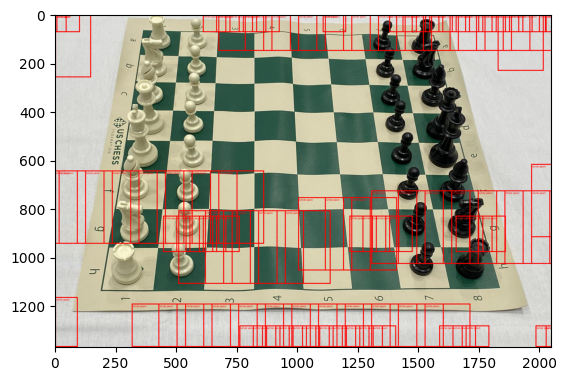

In [ ]:
# Inferencja na zadanym obrazie
preprocess = M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms() # to wystarczy pobrać raz
img = read_image(os.path.join(DATASET_ROOT, 'test/IMG_0159_JPG.rf.1cf4f243b5072d63e492711720df35f7.jpg'))
batch = [preprocess(img).to(DEVICE)]

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    prediction = model(batch)[0]

# Rysowanie predykcji - wygodny gotowiec
box = draw_bounding_boxes(
  img,
  boxes=prediction['boxes'],
  labels=[chess_train.coco.cats[i.item()]['name'] for i in prediction['labels']],
  colors='red',
  width=4,
)



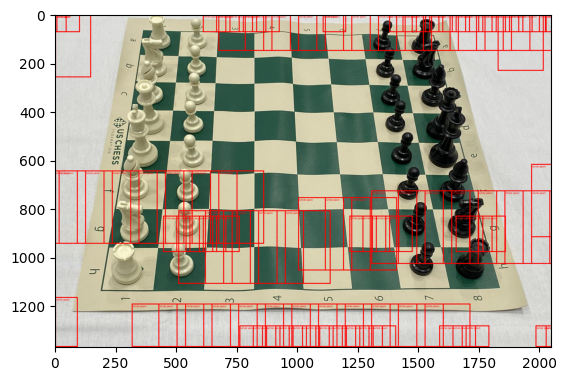

In [44]:

plt.imshow(to_pil_image(box.detach()))
# to_pil_image(box.detach()).show()

---
### Zadanie 1

Zbadaj wpływ parametrów inferencji **głowic `RoIHeads`**, progu prawdopodobieństwa (`score_thresh`) i progu NMS (`nms_thresh`), na działanie modelu. Wykorzystaj funkcję `evaluate` aby zmierzyć zmianę jakości predykcji, ale przebadaj też efekty wizualnie, wyświetlając predykcje dla kilku obrazów ze zbioru walidacyjnego i kilku spoza zbioru (folder `wild`). _W finalnej wersji pozostaw tylko wybrane interesujące przykłady._

 # remove low scoring boxes
            inds = torch.where(scores > self.score_thresh)[0]
            boxes, scores, labels = boxes[inds], scores[inds], labels[inds]

Evaluating with score_thresh=0.3 and nms_thresh=0.3


/Users/filipstrozik/Documents/studies/IISEM/image-and-video-processing/.venv/lib/python3.12/site-packages/torchvision/utils.py:211: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


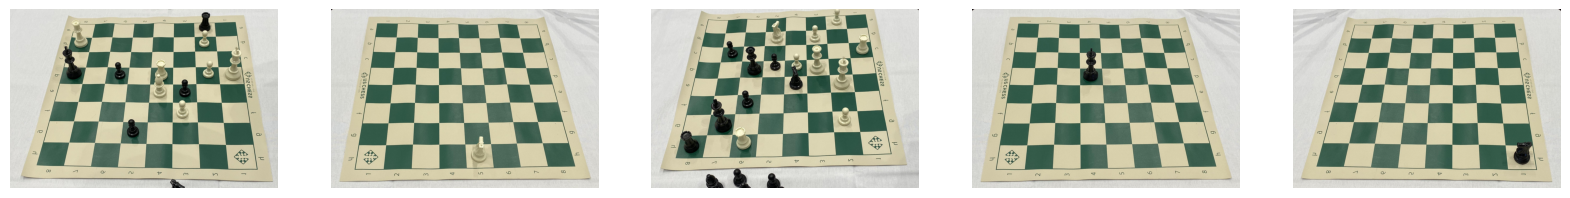

Evaluating with score_thresh=0.3 and nms_thresh=0.5


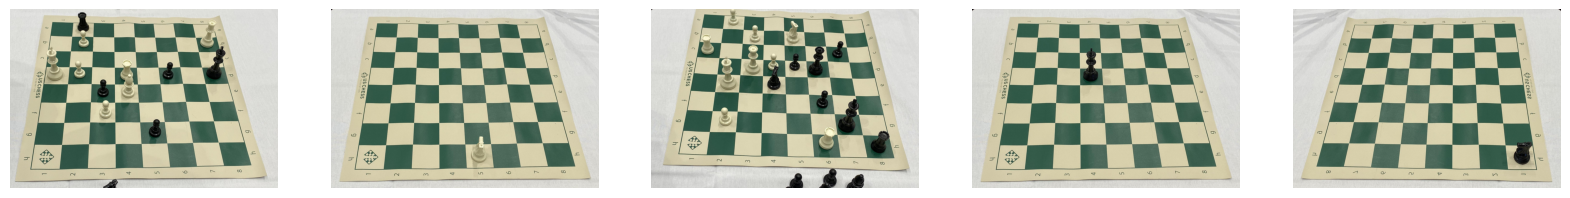

Evaluating with score_thresh=0.3 and nms_thresh=0.7


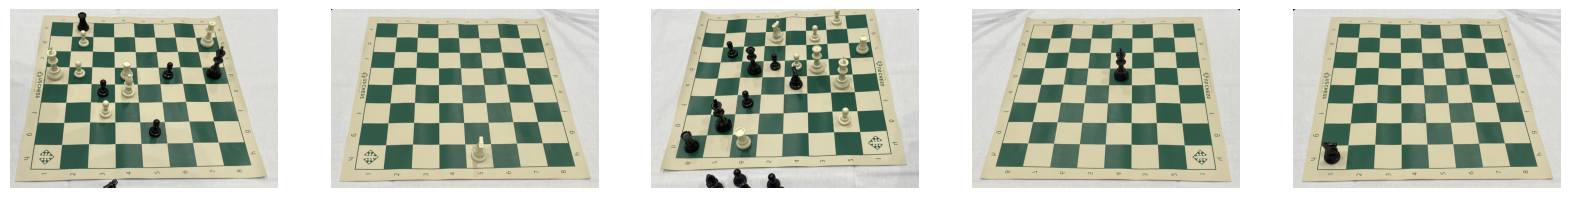

Evaluating with score_thresh=0.5 and nms_thresh=0.3


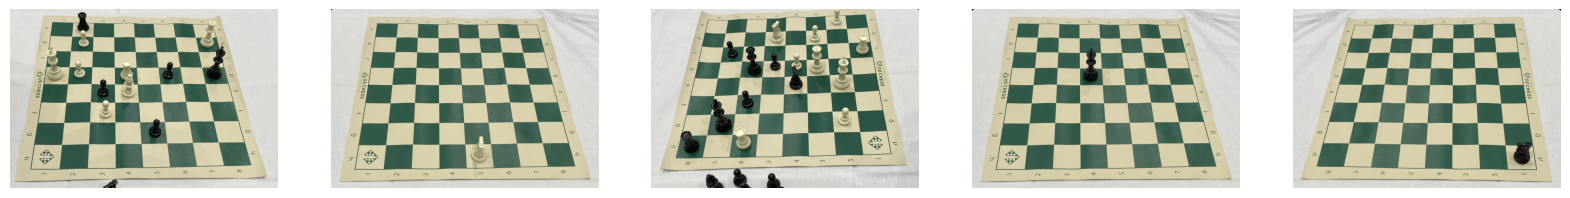

Evaluating with score_thresh=0.5 and nms_thresh=0.5


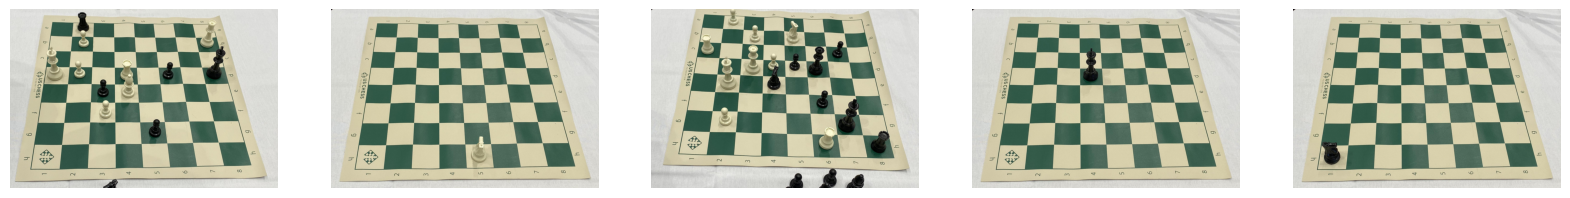

Evaluating with score_thresh=0.5 and nms_thresh=0.7


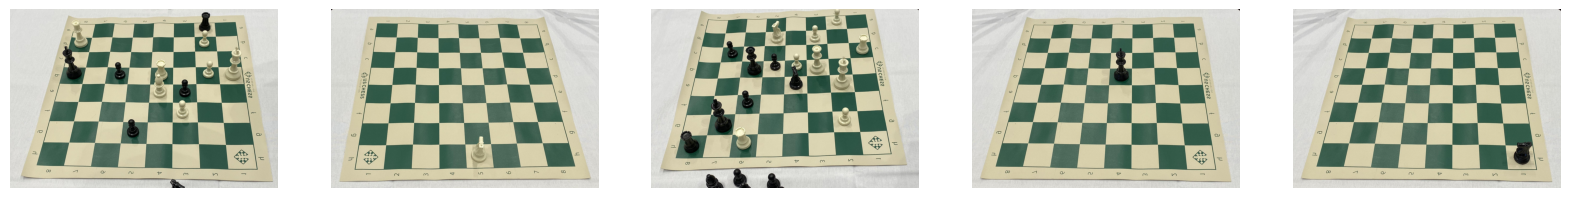

Evaluating with score_thresh=0.7 and nms_thresh=0.3


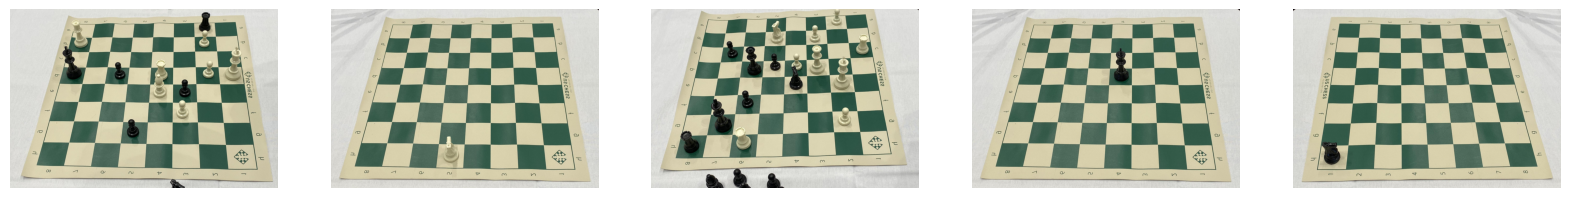

Evaluating with score_thresh=0.7 and nms_thresh=0.5


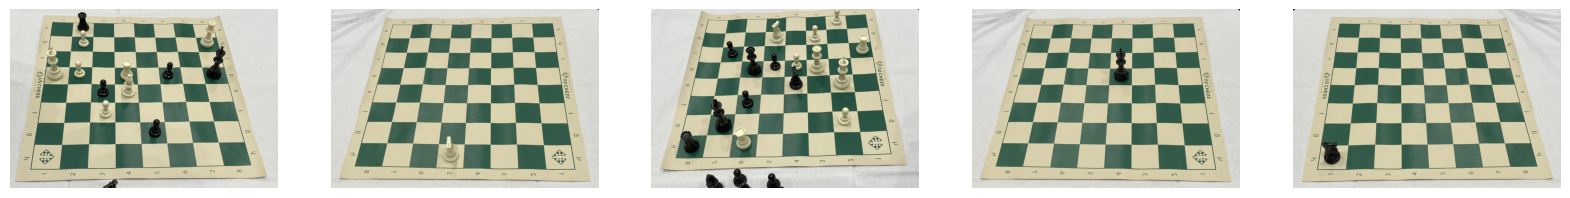

Evaluating with score_thresh=0.7 and nms_thresh=0.7


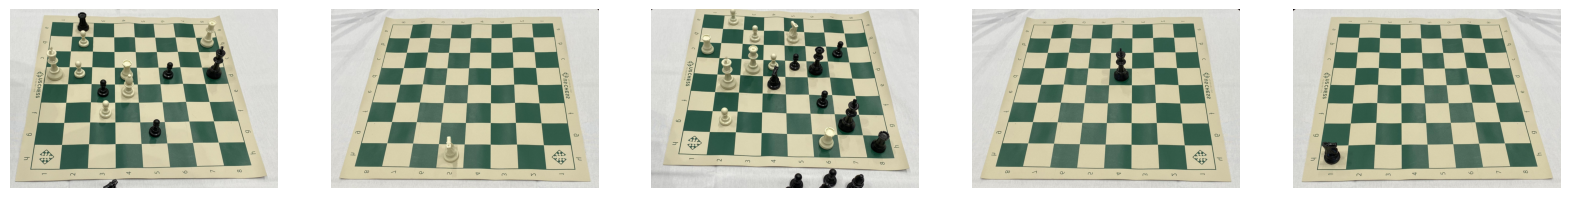

FileNotFoundError: [Errno 2] No such file or directory: 'dane/chess/wild'

In [45]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, device, score_thresh=0.5, nms_thresh=0.5, num_images=5):
    model.roi_heads.score_thresh = score_thresh
    model.roi_heads.nms_thresh = nms_thresh
    model.eval()

    fig, axs = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img, _ = dataset[i]
        img = img.to(device)
        with torch.no_grad():
            prediction = model([img])[0]

        box = draw_bounding_boxes(
            img.cpu(),
            boxes=prediction['boxes'],
            labels=[dataset.coco.cats[i.item()]['name'] for i in prediction['labels']],
            colors='red',
            width=4,
        )
        axs[i].imshow(to_pil_image(box.detach()))
        axs[i].axis('off')
    plt.show()

# Evaluate the model with different thresholds
score_thresholds = [0.3, 0.5, 0.7]
nms_thresholds = [0.3, 0.5, 0.7]

for score_thresh in score_thresholds:
    for nms_thresh in nms_thresholds:
        print(f"Evaluating with score_thresh={score_thresh} and nms_thresh={nms_thresh}")
        # evaluate(model, val_loader, device=DEVICE)
        visualize_predictions(model, chess_val, DEVICE, score_thresh, nms_thresh)

# Visualize predictions for images outside the dataset (folder 'wild')
wild_images = [os.path.join(DATASET_ROOT, 'wild', img) for img in os.listdir(os.path.join(DATASET_ROOT, 'wild'))]
for img_path in wild_images[:5]:  # Visualize first 5 images
    img = read_image(img_path)
    batch = [preprocess(img).to(DEVICE)]
    with torch.no_grad():
        prediction = model(batch)[0]

    box = draw_bounding_boxes(
        img,
        boxes=prediction['boxes'],
        labels=[chess_train.coco.cats[i.item()]['name'] for i in prediction['labels']],
        colors='red',
        width=4,
    )
    to_pil_image(box.detach()).show()

### Zadanie 2a

Zwizualizuj propozycje rejonów wygenerowane przez RPN i porównaj z ostateczną predykcją.

W tym celu konieczne będzie manualne wykonanie fragmentu metody `GeneralizedRCNN::forward` (patrz: [kod](https://github.com/pytorch/vision/blob/6279faa88a3fe7de49bf58284d31e3941b768522/torchvision/models/detection/generalized_rcnn.py#L46), link do wersji najnowszej na grudzień 2024).
Wszystkie fragmenty związane z uczeniem możesz rzecz jasna pominąć; chodzi o wyciągnięcie obiektu `proposals`.
Nie zapomnij o wykonaniu powrotnej transformacji! (Po co?)

### Zadanie 2b

Zbadaj wpływ progu NMS _na etapie propozycji_ na jakość predykcji oraz czas ich uzyskania.
Jak w poprzednich zadaniach, postaraj się nie ograniczyć tylko do pokazania metryk, ale pokaż wizualizacje (propozycji i predykcji) dla **wybranych** przykładów.